# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
#%load_ext autoreload
#%autoreload 2

# local modules
import modelproject as ip

# Model description

**Descriping the model:**

We consider a version of the Ramsey model with population growing at rate $1+n$.


**Households maximize** the intertemporal utility function:

$$
\begin{aligned}
U =& \max_{c_{t}}\sum_{t=0}^{\infty}\beta^{t}(1+n)^{t}\frac{c_{t}^{1-\theta}}{1-\theta}\\
 & \text{s.t.}\\
 & a_{t+1}(1+n)=a_tR_t+w_t-c_t
\end{aligned}
$$
where $c_t$ is consumption per capita, $\beta$ is the discount rate, $\theta$ is the coefficient of relative risk aversion and $a_t$ .
with $a_0>0$ given and $R_t=1+r_t-\delta$ implies that return on household savings ($R_t$) must equal the rental rate on capital paid by firms ($r_t$) plus the undepreciated capital ($1-\delta$)
It is assumed $\beta(1+n)<1$ and $\theta>0$



The Lagrangian of the representative household's optimization problem is:
$$
\begin{equation*}
L=\sum_{t=0}^{\infty}\beta^{t}(1+n)^{t}\left[\frac{c_{t}^{1-\theta}}{1-\theta}-\mu_t\left(a_{t+1}(1+n)-(1+r_t-\delta)a_t-w_t+c_t\right)\right]
\end{equation*}
$$
where $\mu_t=\frac{\lambda_t}{\beta^t(1+n)^t}$

The FOC's are:
$$
\begin{aligned}
\frac{\partial L}{\partial c_t}=0 &\Leftrightarrow \mu_t=c_t^{-\theta} \\
\frac{\partial L}{\partial a_{t+1}}=0 &\Leftrightarrow \beta \mu_{t+1}(1+r_{t+1}-\delta)
\end{aligned}
$$

Which combined yields the Euler equation, describing the households optimal consumption path:
$$
\begin{equation*}
c_t^{-\theta}=\beta c_{t+1}^{-\theta}(1+r_{t+1}-\delta) \Leftrightarrow \frac{c_{t+1} }{c_t} = \left(\beta(1+r_{t+1}-\delta)\right)^{\frac{1}{\theta}}
\end{equation*}
$$
where $\frac{1}{\theta}$ is the elasticity of substitution, which is a measure of how willing the household is to substitute a unit of consumption today for a unit of consumption tomorrow.

**Identical competitive firms maximize** the profit function:

$$
\begin{equation*}
\pi^F(K_t,L_t)=A K_t^{\alpha}(L_t)^{1-\alpha}-w_tL_t-r_tK_t
\end{equation*}
$$

where $L_t$ is labor, $K_t$ is capital, $w_t$ is the wage rate, $r_t$ is the rental rate.

Profit maximization yields:
$$
\begin{aligned}
r_t =& A\alpha k_t^{\alpha-1} \\
w_t =& A(1-\alpha) k_t^{\alpha}
\end{aligned}
$$
where $k_t=\frac{K_t}{L_t}$ is capital per capita.

Furthermore, the goods market clearing condition is:
$$
Y_t=c_t+I_t
$$
where $Y_t=F(K_t,L_t)$

And capital follows the law of motion:
$$
K_t=(1-\delta)K_{t-1}+I_t
$$


**Solution Algorithm:**

We define a function $H_t$ for the transition paths of the economy:
$$
\begin{aligned}
H_{t}
=\left[\begin{array}{c}
c_t^{-\theta}-\beta c_{t+1}^{-\theta}(1+r_{t+1}-\delta)\\
K_t-\left[(1-\delta)K_{t-1}+Y_t-c_t\right]
\end{array}\right]
\quad \text{where } t\in (0,\infty)
\end{aligned}
$$  

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

In [33]:
#from modelproject import RamseyModel

In [47]:
import numpy as np
from types import SimpleNamespace
from scipy import optimize

class RamseyModel():

    def initialmodel(self):
        """ create model 
        
        NB: The self parameter is a reference to the current instance of the class, and is used to access variables that belongs to the class.
        
        """
        
        self.par = SimpleNamespace()
        self.ss = SimpleNamespace()
        self.path = SimpleNamespace()
        
        self.setup()
        self.allocate()

    def setup(self):
        """ parameters of the model """

        par = self.par

        par.alpha = 0.3 # capital share
        par.beta = np.nan # discount factor
        par.delta = 0.05 # depreciation rate
        par.theta = 2 # coefficient of constant relative risk aversion (CRRA)
        par.A = 1 # technology
        par.K_initial = 1.0
        par.transition_path = 500 
    
    def allocate(self):
        """ allocate arrays for transition path """
        
        par = self.par
        path = self.path

        allvariables = ['K','C','w','r','Y','K_lag']

        for variablename in allvariables:
            setattr(path, variablename, np.nan*np.ones(par.transition_path))
    
    def steady_state(self, KY_ss, do_print=True):
        """ find steady state """

        par = self.par
        ss = self.ss
       
        ss.K = KY_ss
        Y,_,_ = production(par,1.0,ss.K)
        ss.A = 1/Y
        
        # factor prices
        ss.Y, ss.r, ss.w = production(par,ss.A, ss.K)
        assert np.isclose(ss.Y, 1.0)
        
        # implied discount factor
        par.beta = 1/(1+ss.r)

        # consumption (goods market clear Y = C + I, I = delta*K)
        ss.C = ss.Y - par.delta*ss.K 

        if do_print:

            print(f'Y_ss = {ss.Y:.4f}')
            print(f'K_ss/Y_ss = {ss.K/ss.Y:.4f}')
            print(f'r_ss = {ss.r:.4f}')
            print(f'w_ss = {ss.w:.4f}')
            print(f'beta = {par.beta:.4f}')
        
    def evaluate_path_errors(self):
        """ evaluate errors """

        par = self.par
        ss = self.ss
        path = self.path
  
        C = path.C
        C_plus = np.append(path.C[1:], ss.C)

        K = path.K
        K_lag = path.K_lag = np.insert(K[:-1],0, par.K_initial)

        path.Y, path.r, path.w = production(par, K_lag)
        r_plus = np.append(path.r[1:], ss.r)

        errors = np.nan*np.ones((2, par.transition_path))
        errors[0,:] = C**(-par.theta) - par.beta*(1+r_plus)*C_plus**(-par.theta)
        errors[1,:] = K - ((1-par.delta)*K_lag + path.Y - C)
        
        return errors.ravel()
        
    def calculate_jacobian(self, h = 1e-6):
        """ calculate jacobian """
        
        par = self.par
        ss = self.ss
        path = self.path
        
        # a. allocate
        Njac = 2*par.transition_path
        jac = self.jac = np.nan*np.ones((Njac,Njac))
        
        x_ss = np.nan*np.ones((2,par.transition_path))
        x_ss[0,:] = ss.C
        x_ss[1,:] = ss.K
        x_ss = x_ss.ravel()

        # b. baseline errors
        path.C[:] = ss.C
        path.K[:] = ss.K
        base = self.evaluate_path_errors()

        # c. jacobian
        for i in range(Njac):
            
            # i. add small number to a single x (single K or C) 
            x_jac = x_ss.copy()
            x_jac[i] += h
            x_jac = x_jac.reshape((2, par.transition_path))
            
            # ii. alternative errors
            path.C[:] = x_jac[0,:]
            path.K[:] = x_jac[1,:]
            alt = self.evaluate_path_errors()

            # iii. numerical derivative
            jac[:,i] = (alt-base)/h
        
    def solve(self):
        """ solve for the transition path """

        par = self.par
        ss = self.ss
        path = self.path
        
        # a. equation system
        def eq_sys(x):
            
            # i. update
            x = x.reshape((2, par.transition_path))
            path.C[:] = x[0,:]
            path.K[:] = x[1,:]
            
            # ii. return errors
            return self.evaluate_path_errors()

        # b. initial guess
        x0 = np.nan*np.ones((2, par.transition_path))
        x0[0,:] = ss.C
        x0[1,:] = ss.K
        x0 = x0.ravel()

        # c. call solver
        root = optimize.root(eq_sys, x0, method='hybr', options={'factor':1.0})
            # the factor determines the size of the initial step
            # too low: slow
            # too high: prone to errors

        x = root.x
            
        # d. final evaluation
        eq_sys(x)

def production(par, A, K_lag):
    """ production and factor prices """

    # a. production
    Y = A*K_lag**par.alpha * 1**(1-par.alpha)

    # b. factor prices
    r = A*par.alpha * K_lag**(par.alpha-1) * 1**(1-par.alpha)
    w = A*(1-par.alpha) * K_lag**(par.alpha) * 1**(-par.alpha)

    return Y,r,w            

def broyden_solver(f, x0, jac, tol=1e-8, maxiter=100, do_print=False):
    """ numerical equation system solver using the broyden method 
    
        f (callable): function return errors in equation system
        jac (ndarray): initial jacobian
        tol (float,optional): tolerance
        maxiter (int,optional): maximum number of iterations
        do_print (bool,optional): print progress

    """

    # a. initial
    x = x0.ravel()
    y = f(x)

    # b. iterate
    for it in range(maxiter):
        
        # i. current difference
        abs_diff = np.max(np.abs(y))
        if do_print: print(f' it = {it:3d} -> max. abs. error = {abs_diff:12.8f}')

        if abs_diff < tol: return x
        
        # ii. new x
        dx = np.linalg.solve(jac,-y)
        assert not np.any(np.isnan(dx))
        
        # iii. evaluate
        ynew = f(x+dx)
        dy = ynew-y
        jac = jac + np.outer(((dy - jac @ dx) / np.linalg.norm(dx)**2), dx)
        y = ynew
        x += dx
            
    else:

        raise ValueError(f'no convergence after {maxiter} iterations')        

In [48]:
model = RamseyModel()

model.initialmodel() # initilizaing
model.setup()
model.allocate()

par = model.par
ss = model.ss
path = model.path

In [49]:
model.steady_state(KY_ss=4.0)

Y_ss = 1.0000
K_ss/Y_ss = 4.0000
r_ss = 0.0750
w_ss = 0.7000
beta = 0.9302


In [5]:
# a. set initial value
par.K_initial = ss.K

# b. set path
path.C[:] = ss.C
path.K[:] = ss.K

# c. check errors
errors_ss = model.evaluate_path_errors()
# assert np.allclose(errors_ss, 0.0)

In [6]:
model.calculate_jacobian()

In [7]:
par.K_initial = 0.50*ss.K # start away from steady state
model.solve() # find transition path

/Users/christopher/Documents/Python/projects-2022-christopher-mie-og-emma/modelproject.py:169: RuntimeWarning: invalid value encountered in power
  Y = par.A*K_lag**par.alpha * 1**(1-par.alpha)
/Users/christopher/Documents/Python/projects-2022-christopher-mie-og-emma/modelproject.py:172: RuntimeWarning: invalid value encountered in power
  r = par.A*par.alpha * K_lag**(par.alpha-1) * 1**(1-par.alpha)
/Users/christopher/Documents/Python/projects-2022-christopher-mie-og-emma/modelproject.py:173: RuntimeWarning: invalid value encountered in power
  w = par.A*(1-par.alpha) * K_lag**(par.alpha) * 1**(-par.alpha)


# Further analysis

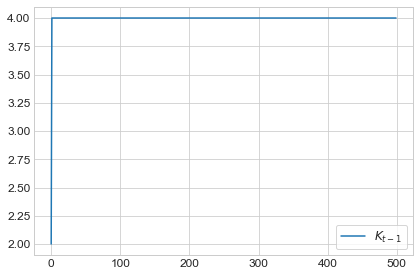

In [8]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(path.K_lag,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 